# Mandelbrot's poisoned chalice

This is a shameless ripoff of an idea of Gabriel and Bernat
who used [chimera](https://www.cgl.ucsf.edu/chimera/)
to get an STL file from a multi image TIFF by stacking layers of voxels.
Below we build a TIFF for importing in Chimera.


Each level set is a Julia set with the corresponding $c$
in $f_c(z) = z^2 + c$ either:

- on a semicircle of radius  $\frac14$ centered at $0$
- on a segment between $-\frac14$ and $0$


Theoretically we can use Chimera directly from a notebook
with [this package](https://pypi.org/project/pychimera/0.1.11/)
but it only works with python 2.7 and I'm tired of building environments.


![chalice](./chalice.png)

if the image doesn't load [click here](https://github.com/macbuse/just-math/blob/master/chalice.png)

![chalice](./chalice2.jpg)

In [46]:
import matplotlib.pyplot as plt
import numpy as np 
import imageio 

# I might run this in notebook and not lab so
%matplotlib inline
# skimage is sensitive about letting u import so....
from skimage.transform import resize, rotate

def mk_gif(frames, fn='weather.gif', duration=.3):
    with imageio.get_writer(fn, mode='I',duration=duration) as writer:
        for frame in frames:
            if frame is None: continue
            writer.append_data(frame)

# Building the profile and a path in the Mandelbrot set

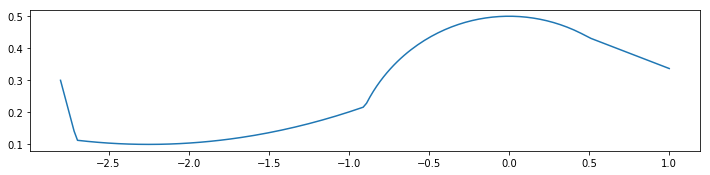

In [44]:
#globals but hey this isn't production code

equator = .5
bottom = -.9
base = 3*bottom
ff = .5

def gg(x):
    #need this for quadratic interpolation
    x_min = .75
    return (x - ((1 - x_min)*bottom + x_min *base))/(bottom - base)


def xm2(t):
    if t < base:
        return .25

    if  t < equator : 
        tt = np.pi*(t - base)/(equator-base)*1J
        return .25*np.exp(tt)
    
    tt = (t - equator)/.5
    return -.25*(1 - tt) 

def profile(t):
    if t < base :
        tt = (t - T[0])/(base-T[0])
        return .3*(1-tt) + tt*profile(B)
    if  t <= bottom :
        tt = (gg(t)/gg(bottom))**2
        return tt*ff*np.sqrt(1 - bottom**2)  + .1*(1-tt)
    
    if  t < equator : return ff*np.sqrt(1 - t**2)
    return ff*np.sqrt(1 - equator**2) + (equator - t)*equator/(np.sqrt(1 - equator**2))/3

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_aspect(2) 
#ax.axis('off')
   

T = np.linspace(base - .1 ,1, 180)
RR = [ profile(t) for t in T ]

ax.plot(T,[ profile(t) for t in T])

# Code I had lying around 

this does the Mandelbrot set but you can get Julia sets by  a couple of small mods

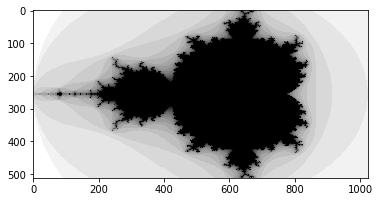

In [3]:
npts = 512
max_iter = 20

X = np.linspace(-2, 1, 2*npts)
Y = np.linspace(-1, 1, npts)

#broadcast the xs to a square array
C = X[:, None] + 1J*Y
#initial value is always zero
Z = np.zeros_like(C)

exit_times = max_iter * np.ones(C.shape, np.int8)
mask = exit_times > 0

for k in range(max_iter):
    Z[mask] = Z[mask] * Z[mask] + C[mask]
    mask, old_mask = abs(Z) < 2, mask
    #use XOR to detect the area which has changed 
    exit_times[mask ^ old_mask] = k
    
#r,g,b layers are all the same
image = np.stack((exit_times,)*3).T
#choose a coloring scheme now
image = 1 - image/max_iter

plt.imshow(image)
    

# Modded code

we need it as a function to run on the path in the Mandelbrot set

In [5]:
def julia(C,
    npts = 512,
    max_iter = 20):

    X = np.linspace(-2, 2, npts)
    Y = np.linspace(-2, 2, npts)
    #broadcast the xs to a square array
    Z = X[:, None] + 1J*Y

    exit_times =  np.ones(Z.shape, np.uint8)
    mask = exit_times > 0

    for k in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C
        mask = abs(Z) < 2
        exit_times[ np.logical_not(mask) ] = 0
    
    return exit_times
    

frames = [julia(xm2(t)) for t in T]

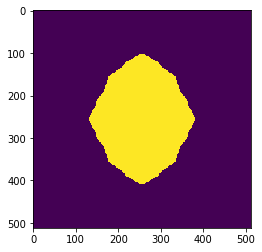

In [20]:
plt.imshow(julia(-.25))

# Now we need to do some post processing

resizing and a little rotation to get texture

In [7]:
def rebox(im,
          ss=.5,
          rr=10):
    
resizing and a little rotation to get texture
    '''change size and rotate a square image
    insert in the middle of a black image 
    of the same size as original'''
    
    sx, sy = im.shape
    
    #so I want to stay in uint8 so I preserve range
    layer = resize(im, (2*int(sx*ss), 2*int(sy*ss)),  preserve_range=True)
    
    layer = rotate(layer, rr)
    
    dx, dy = layer.shape
    cx = sx//2 -  dx//2
    
    blk = np.zeros((sx,sx), dtype=np.uint8)
    #glue it in there baby
    blk[cx:cx + dx, cx:cx + dx] = layer[:]  
    return blk


## Output

we need to pad out the base so that it is solid
and save to a multi image TIFF

In [41]:
movie = [frames[0]]*6
movie.extend(frames)

R = [RR[0]]*6
R.extend(RR)

In [42]:
ims = [ 255*rebox(layer, r, 0) for layer,r,k in zip(movie, R, range(1000)) ]
imageio.mimsave('glass.tiff', ims)

/home/gregmcshane/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [43]:
mk_gif(movie, fn='pp.gif')